# Options Project

*By Daniel Deutsch and José Lucas Barretto*

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import yfinance as yf
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Question 1

For this project we decided to use Apple stocks as our underlying asset for the option we intend to create. Thus, we download its historical data through YahooFinance's python library and use __ as the risk free rate.

In [3]:
df = yf.download('AAPL', progress=False, show_errors=False)
df.rename(columns=str.lower, inplace=True)
df = df.loc['2021-03-11':'2022-03-11', ['close', 'adj close']]
df

,close,adj close
Date,,
2021-03-11,121.959999,121.239403
2021-03-12,121.029999,120.314911
2021-03-15,123.989998,123.257416
2021-03-16,125.570000,124.828079
2021-03-17,124.760002,124.022865
...,...,...
2022-03-07,159.300003,159.300003
2022-03-08,157.440002,157.440002
2022-03-09,162.949997,162.949997


# Question 2

## a) Risk-Free Rate

For the risk-free rate we decided to use [Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity](https://fred.stlouisfed.org/series/DGS1). The value we are using is for March 11th 2022.

In [4]:
r = 0.0122

## b) Projection Period

The projection period used in this project should match the maturity of the risk-free rate chosen. Therefore, in our case, T should be 1 year.

In [5]:
T = 1

## c) Annualized Volatility

The annualized volatility can be calculated through the following formula:

\begin{align*}
    \sigma_a & = \sigma_{daily} * \sqrt{\text{trading days in a year}}
\end{align*}

Note that the standar deviation is calculated using data covering a period equal to the length of the maturity T, so we will consider AAPL stock prices from 11 March 2021 to 11 March 2022.

In [6]:
sigma = df['close'].pct_change().std()*np.sqrt(253)

# Question 3

In [7]:
# Obtains the strike prices as requested
X1 = df['close'].mean()
X2 = 1.1*df['close'].iloc[-1]

## a) American Options Using Two-Step BOPM

In [8]:
def BOPM(S, X, sigma, r, T, N, _type='american', _action='call'):
    """_summary_

    Args:
        S (float): Market price of the underlying at initial date
        X (float): Strike price of the underlying at maturity T
        sigma (float): annualized volatility of the underlying asset's returns
        r (float): risk free rate
        T (int): Maturity
        N (int): Number of timesteps
        _type (str, optional): Type of the option (either 'american' or 'european'). Defaults to 'american'.
        _action (str, optional): Action to be performed (either 'call' or 'put'). Defaults to 'call'.

    Returns:
        _type_: _description_
    """
    
    # Calculates variables
    dt = T/N
    u = np.exp( sigma * np.sqrt(dt) )
    d =  np.exp( -sigma * np.sqrt(dt) )
    pi_u = ( np.exp(r*dt) - d) / (u - d)

    # Instantiates arrays
    stock_prices = np.zeros((N+1, N+1))
    intrinsic_values = np.zeros((N+1, N+1))
    option_prices = np.zeros((N+1, N+1))

    # Fills the intrinsic value and stock arrays
    for i in range(N+1):
        for j in range(i+1):
            stock_prices[i, j] = S * u**j * d**(i-j)
            if _action == 'call':
                intrinsic_values[i, j] = max(stock_prices[i, j] - X, 0)
            elif _action == 'put':
                intrinsic_values[i, j] = max(X - stock_prices[i, j], 0)

    # Calculates the option array
    option_prices[option_prices.shape[0]-1, :] = intrinsic_values[intrinsic_values.shape[0]-1, :]
    for i in list(range(N))[::-1]:
        for j in list(range(i+1)):
            option_prices[i, j] = ((1-pi_u)*option_prices[i+1, j] + pi_u*option_prices[i+1, j+1])/np.exp(r*dt)

    # for american options, substitute the european option price with the maximum between the price and the intrinsic value
    if _type=='american':
        option_prices = np.maximum(option_prices, intrinsic_values)

    return option_prices[0, 0], option_prices, stock_prices


def plot_tree(option_prices):

    n, _ = option_prices.shape

    G = nx.Graph()
    for i in range(0, n+1):
        for j in range(1, i+1):
            if i < n:
                G.add_edge( (i, j), (i+1, j) )
                G.add_edge( (i, j), (i+1, j+1) )

    nx.draw(
        G,
        node_size=1600,
        pos={ node: ( node[0], n+2+node[0]-2*node[1] ) for node in G.nodes() },
        labels={ node: f"${price:.2f}" for node, price in zip(G.nodes(), option_prices[np.tril_indices(option_prices.shape[0])] ) }
    )
    plt.show()   


### Call

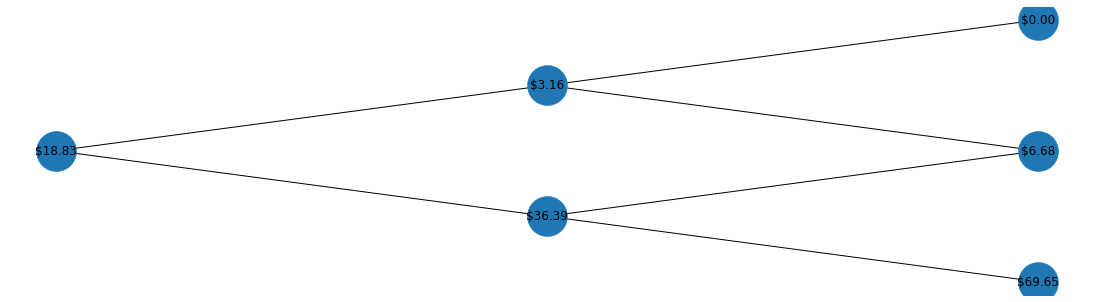

In [9]:
price, option_prices, stock_prices = BOPM(df['close'].iloc[-1], X1, sigma, r, T, 2, _type='american', _action='call')
plot_tree(option_prices)

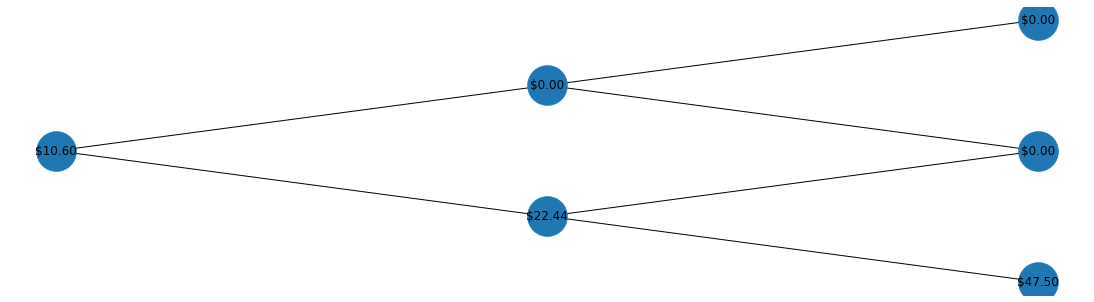

In [10]:
price, option_prices, stock_prices = BOPM(df['close'].iloc[-1], X2, sigma, r, T, 2, _type='american', _action='call')
plot_tree(option_prices)

### Put

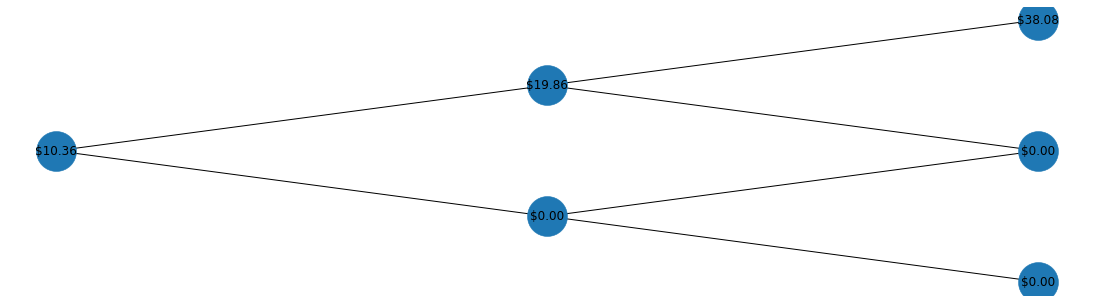

In [11]:
price, option_prices, stock_prices = BOPM(df['close'].iloc[-1], X1, sigma, r, T, 2, _type='american', _action='put')
plot_tree(option_prices)

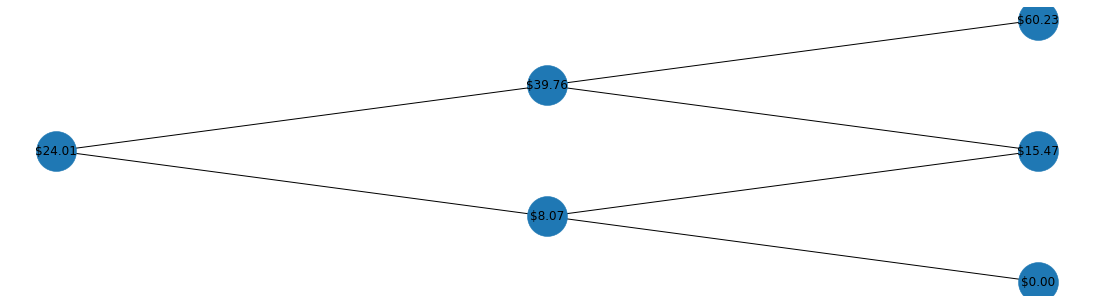

In [12]:
price, option_prices, stock_prices = BOPM(df['close'].iloc[-1], X2, sigma, r, T, 2, _type='american', _action='put')
plot_tree(option_prices)

## b) European Options Using BSMOPM

In [13]:
def BSMOPM(S, X, sigma, r, T, _type='american', action_='call'):
    
    d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    C = S*stats.norm.cdf(d1) - X*np.exp(-r*T)*stats.norm.cdf(d2)
    P = C - S + (X*np.exp(-r*T))

    return C if action_ == 'call' else P

### Put

In [14]:
price = BSMOPM(df['adj close'].iloc[-1], X1, sigma, r, T, action_='put')
price

10.612599606065032

In [15]:
price = BSMOPM(df['adj close'].iloc[-1], X2, sigma, r, T, action_='put')
price

23.121450518202636

### Call

In [16]:
price = BSMOPM(df['adj close'].iloc[-1], X1, sigma, r, T, action_='call')
price

19.087948688803692

In [17]:
price = BSMOPM(df['adj close'].iloc[-1], X2, sigma, r, T, action_='call')
price

9.71231233493915

## c) Model Comparison

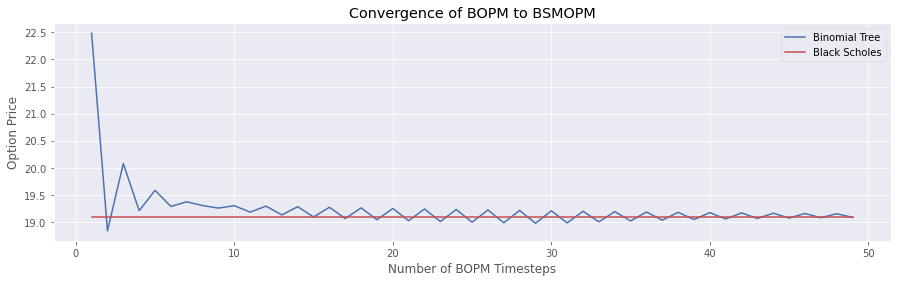

In [18]:
# Global parameters
S = df['adj close'].iloc[-1]
X = X1

binomial_tree, black_scholes = [], []
for N in range(1, 50):

    # Appends binomial tree price
    price, _, __ = BOPM(S, X, sigma, r, T, N)
    binomial_tree.append(price)

    # Appends Black Scholes price
    price = BSMOPM(S, X, sigma, r, T)
    black_scholes.append(price)

# Plot
plt.plot(range(1, 50), binomial_tree, label="Binomial Tree")
plt.plot(range(1, 50), black_scholes, label="Black Scholes")
plt.title("Convergence of BOPM to BSMOPM")
plt.ylabel("Option Price")
plt.xlabel("Number of BOPM Timesteps")
plt.legend()
plt.show()

From the plot above one can observe that the Binary Tree Model tends to converge to the same value as the one obtained through the Black and Scholes method.

# Question 4

## a) Calculating Delta

$\Delta$ measures the change in price of an option ($O$), relative to the change in price of the option’s underlying asset ($S$). Therefore, when the asset’s price changes, so does the delta. Mathematically:

\begin{align*}
    \Delta & = \frac{\partial O}{\partial S}
\end{align*}

For European options, delta can be calculated as the $\mathcal{N}(d_1)$ from the Black-Scholes-Merton option pricing model:

\begin{cases}
    \Delta_{\text{call}} & = \mathcal{N}\left(\frac{ln\left(\frac{S_0}{X}\right) + \left(r + \frac{\sigma^2}{2} \right)*T}{\sigma \sqrt{T}}\right) \\
    \Delta_{\text{put}} & = \mathcal{N}\left(\frac{ln\left(\frac{S_0}{X}\right) + \left(r + \frac{\sigma^2}{2} \right)*T}{\sigma \sqrt{T}}\right) - 1
\end{cases}

### European Call

In [19]:
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1)

print(f"When AAPL stock price changes by $1, the option will change by ${delta:.3f}.")

When AAPL stock price changes by $1, the option will change by $0.638.


### European Put

In [20]:
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1) - 1

print(f"When AAPL stock price changes by $1, the option will change by ${delta:.3f}.")

When AAPL stock price changes by $1, the option will change by $-0.362.


## b) Delta-Neutral Portfolio

Delta neutrality describes a portfolio composed of financial assets and their related options, such that the value of the portfolio remains unchanged when small changes occur in the value of the financial assets’ prices.

### Covered Call

A portfolio composed of $x$ long (=buying) shares of Apple stock and $y$ short (=selling) call options of AAPL. Therefore, an investor is buying $x$ shares of Apple and selling $y$ Apple call options.

For a hedge (protection) using call options, the following mathematical formula is applied:

\begin{align*}
    \text{Number of call options needed to hedge} & = \frac{\text{Number of shares of an asset}}{\text{Delta of the call option}}
\end{align*}

In [21]:
# Defines the number of AAPL shares
n_shares = 23000

# Calculate the delta for the call option
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1)

# Calculates the the number of options necessary to create a delta-neutral portfolio
n_options = n_shares/delta

print(f"Delta: {delta:.3f}")
print(f"To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to sell {n_options:.3f} AAPL call options.")

Delta: 0.638
To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to sell 36030.695 AAPL call options.


### Protective Put

A portfolio composed of $x$ long (=buying) shares of Apple stock and $y$ long (=buying) put options of AAPL. Therefore, an investor is buying $x$ shares of Apple and buying $y$ Apple put options.

For a hedge (protection) using put options, the following mathematical formula is applied:

\begin{align*}
    \text{Number of put options needed to hedge} & = \frac{-\text{Number of shares of an asset}}{\text{Delta of the call option}}
\end{align*}

In [22]:
# Defines the number of AAPL shares
n_shares = 23000

# Calculate the delta for the put option
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1) - 1

# Calculates the the number of options necessary to create a delta-neutral portfolio
n_options = -n_shares/delta

print(f"Delta: {delta:.3f}")
print(f"To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to buy {n_options:.3f} AAPL put options.")

Delta: -0.362
To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to buy 63596.453 AAPL put options.


## c and d) Effects on Delta-Neutral Portfolio

Now let's see what happens to delta and to the delta-neutral portfolio if the price of the asset increases by $0.85.

### Covered Call

In [23]:
# Defines the number of AAPL shares
n_shares = 23000

# Calculate the delta for the call option
d1 = (np.log((S+0.85)/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1)

# Calculates the the number of options necessary to create a delta-neutral portfolio
n_options = n_shares/delta

print(f"Delta: {delta:.3f}")
print(f"To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to sell {n_options:.3f} AAPL call options.")

Delta: 0.647
To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to sell 35559.014 AAPL call options.


As seen from the output above, if an AAPL stock increases its price by $0.85, considering a covered call strategy, to keep a delta-neutral portfolio, it would be necessary to buy 471 options.

### Protective Put

In [24]:
# Defines the number of AAPL shares
n_shares = 23000

# Calculate the delta for the put option
d1 = (np.log((S+0.85)/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1) - 1

# Calculates the the number of options necessary to create a delta-neutral portfolio
n_options = -n_shares/delta

print(f"Delta: {delta:.3f}")
print(f"To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to buy {n_options:.3f} AAPL put options.")

Delta: -0.353
To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to buy 65121.141 AAPL put options.


As seen from the output above, if an AAPL stock increases its price by $0.85, the delta values also change. For this reason, to maintain delta-neutrality, it is necessary to rebalance the portfolio. For example, considering a covered call strategy, to keep a delta-neutral portfolio, it would be necessary to sell 1525 options.

# Question 5

## a) Calculating Gamma

$\Gamma$ measures the expected change in $\Delta$ of an option $O$. If $\Delta$ is changing significantly, the price of its option $O$, will be very volatile. For European options, $\Gamma$ is calculated as follows:

\begin{align*}
    \Gamma & = \frac{\mathcal{N'}(d_1)}{S_0 \sigma \sqrt{T}}
\end{align*}

Where $\mathcal{N'} = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$.

Let's consider a covered call strategy, and following question 4 we will consider the current stock price as well as the current stock price with a $0.85 increase.

In [25]:
# Defines the number of AAPL shares
n_shares = 23000

# Calculate the delta for the call option at S
d1 = (np.log((S)/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
gamma = ((1/np.sqrt(2*np.pi))*np.exp(-(d1**2)/2))/((S)*sigma*np.sqrt(T))

print(f"For a $1 change in the price of the stock at ${S:.2f}, delta will change by {gamma:.5f}.")

# Calculate the delta for the call option at S+0.85
d1 = (np.log((S+0.85)/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
gamma = ((1/np.sqrt(2*np.pi))*np.exp(-(d1**2)/2))/((S+0.85)*sigma*np.sqrt(T))

print(f"For a $1 change in the price of the stock at ${S+0.85:.2f}, delta will change by {gamma:.5f}.")

For a $1 change in the price of the stock at $154.73, delta will change by 0.01003.
For a $1 change in the price of the stock at $155.58, delta will change by 0.00989.


Again, we see that the value of gamma changes for different values of the underlying asset.

## b) Gamma-Neutral Position

Assume we want to gamma-hedge a covered-call, delta neutral, portfolio composed of $x$ long (=buying) shares of Apple stock and $y$ short (=selling) call options of AAPL. Therefore, an investor is buying $x$ shares of Apple and selling $y$ Apple call options. The covered-call portfolio for $x=23000$ is:

In [26]:
# Defines the number of AAPL shares
n_shares = 23000

# Calculate the delta for the call option
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
delta = stats.norm.cdf(d1)

# Calculates the the number of options necessary to create a delta-neutral portfolio
n_options = n_shares/delta

print(f"Delta: {delta:.3f}")
print(f"To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to sell {n_options:.3f} AAPL call options.")

Delta: 0.638
To create a delta-neutral portfolio that longs 23000 shares of AAPL stock, it would be necessary to sell 36030.695 AAPL call options.


Now, let's calculate the gamma-neutral position for this portfolio.

In [27]:
# gamma greek position of the current portfolio (negative because we are selling options)
gamma = ((1/np.sqrt(2*np.pi))*np.exp(-(d1**2)/2))/((S)*sigma*np.sqrt(T))

gamma_p = - n_options * gamma
print(f"Gamma greek position: {gamma_p:.3f}")

Gamma greek position: -361.392


Now, consider a hypothetical traded option on the underlying asset Z with $\Delta=0.6$ and $\Gamma=1.2$. We can establish a gamma-neutral position by buying (or selling) this option.

In [28]:
n_options_z = -(gamma_p/1.2)
print(f"The gamma neutral position is achieved by buying (or selling, if sign is negative) {n_options_z:.3f} options of asset Z.")

The gamma neutral position is achieved by buying (or selling, if sign is negative) 301.160 options of asset Z.


## c) Portfolio Adjustment

By buying options on Z, the portfolio is no longer delta-neutral. Therefore, we have to rebalance it to obtain delta-gamma neutrality.

In [29]:
delta_z = n_options_z * 0.6
print(f"The current delta greek position on asset Z is {delta_z:.3f}. Therefore, the investor needs to sell (or buy, if sign is negative) {delta_z:.3f} shares of Z to achieve delta-gamma neutrality.")

The current delta greek position on asset Z is 180.696. Therefore, the investor needs to sell (or buy, if sign is negative) 180.696 shares of Z to achieve delta-gamma neutrality.


# Question 6

### Calculate Theta ($\theta$)

We will calculate daily $\theta$ values for both call and put european options.

In [30]:
# calculate constants
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
N_prime = (1/np.sqrt(2*np.pi))*np.exp(-(d1**2)/2)

# european call options
theta_call = - (S*N*sigma)/(2*np.sqrt(T)) - r*X*np.exp(-r*T)*stats.norm.cdf(d2)
theta_call /= 252

# european put options
theta_put = - (S*N*sigma)/(2*np.sqrt(T)) + r*X*np.exp(-r*T)*stats.norm.cdf(-d2)
theta_put /= 252

print(f"The value of an european call option decreases by ${abs(theta_call):.3f} each day.")
print(f"The value of an european put option decreases by ${abs(theta_put):.3f} each day.")

The value of an european call option decreases by $3.636 each day.
The value of an european put option decreases by $3.629 each day.


This means that the value of options decrease as they get closer to maturity.

### Calculate Vega ($\nu$) and then assume 3.4% increase in volatility

In [31]:
N_prime = (1/np.sqrt(2*np.pi))*np.exp(-(d1**2)/2)
vega = S*N_prime*np.sqrt(T)

print(f"Vega: {vega:.3f}")

Vega: 57.978


This means that, for a 1% increase in volatility, the option price will increase by approximately $0.58. 

In case of a 3.4% increase in volatility:

In [32]:
print(f"The value of an european option changes by ${vega*0.034:.3f} for a 3.4‰ increase in volatility.")

The value of an european option changes by $1.971 for a 3.4‰ increase in volatility.


### Calculate Rho ($\rho$) and then assume 0.3% decrease in the risk-free rate

We will calculate $\rho$ values for both call and put european options.

In [33]:
# calculate constants
d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)

# calculate rho
rho_call = X*T*np.exp(-r*T)*stats.norm.cdf(d2)
rho_put = -X*T*np.exp(-r*T)*stats.norm.cdf(-d2)

print(f"The value of an european call option changes by ${rho_call/100:.3f} for every 1‰ increase in RF rate.")
print(f"The value of an european put option changes by ${rho_put/100:.3f} for every 1‰ increase in RF rate.")

The value of an european call option changes by $0.797 for every 1‰ increase in RF rate.
The value of an european put option changes by $-0.666 for every 1‰ increase in RF rate.


In case of a 0.3% decrease in the risk free rate:

In [34]:
print(f"The value of an european call option changes by ${rho_call*-0.003:.3f} for a 0.3‰ decrease in RF rate.")
print(f"The value of an european put option changes by ${rho_put*-0.003:.3f} for a 0.3‰ decrease in RF rate.")

The value of an european call option changes by $-0.239 for a 0.3‰ decrease in RF rate.
The value of an european put option changes by $0.200 for a 0.3‰ decrease in RF rate.
